In [23]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

from models import ASGL
from utils import FeatureSmoothnessLoss, SparseLoss, plot_adjacency_matrix, EarlyStopper

In [20]:
device = "cuda" if torch.cuda.is_available() else "cput"
lambda_CE = 1.
lambda_L2 = 0.
lambda_fs = 0.1
lambda_sparse = 1e-1

dataset = Planetoid(root="data", name="Cora", split="full")
data = dataset[0].to(device)
transform = T.Compose([T.NormalizeFeatures()])
data = transform(data)
A = to_dense_adj(data.edge_index).squeeze(dim=0)
num_features = dataset.num_node_features
num_nodes = data.num_nodes
num_classes = dataset.num_classes


In [21]:
a = torch.linspace(0.1, 1., 10)
p_ASGL = []

for ai in a:
    loss_fn = nn.CrossEntropyLoss()
    loss_A_fn = lambda A_pred: torch.norm(A_pred[data.train_mask] - A[data.train_mask])
    loss_fs_fn = FeatureSmoothnessLoss()
    loss_sparse_fn = SparseLoss(a=ai) # lambda A_pred: torch.norm(A_pred, 1)
    acc_fn = lambda logits, y: ((logits.argmax(dim=-1) == y).sum() / y.shape[0]).item()

    model = ASGL(num_features, num_nodes, num_classes, A=None).to(device)
    optimizer_gcn = torch.optim.Adam(model.gcn.parameters(), lr=1e-1, weight_decay=5e-4)
    optimizer_A = torch.optim.Adam(model.gl.parameters(), lr=1e-1)

    model.train()
    for epoch in range(50):
        logits = model(data)

        # Optimize the GCN
        loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])
        optimizer_gcn.zero_grad()
        loss.backward()
        optimizer_gcn.step()

        acc = acc_fn(logits[data.train_mask], data.y[data.train_mask])

        # Optimize A
        logits = model(data)

        loss_CE = loss_fn(logits[data.train_mask], data.y[data.train_mask])
        loss_L2 = loss_A_fn(model.gl.A)
        loss_fs = loss_fs_fn(data.x, model.gl.A)
        loss_sparse = loss_sparse_fn(model.gl.A)
        loss_A = lambda_CE*loss_CE + lambda_L2*loss_L2 + lambda_fs*loss_fs + lambda_sparse*loss_sparse

        optimizer_A.zero_grad()
        loss_A.backward()
        optimizer_A.step()
        
        #num_edges = model.gl.A.count_nonzero()
        num_edges = (model.gl.A == 1.).sum()
        num_zeros = (model.gl.A == 0.).sum()
        
        # Validation
        model.eval()
        with torch.no_grad():
            logits = model(data)
            val_loss = loss_fn(logits[data.val_mask], data.y[data.val_mask])
            val_acc = acc_fn(logits[data.val_mask], data.y[data.val_mask])
        model.train()
    num_edges = (model.gl.A == 1.).sum()
    p = num_edges / model.gl.A.nelement()
    p_ASGL.append(p.item())
    print(ai, p)

tensor(0.1000) tensor(0.1000, device='cuda:0')
tensor(0.2000) tensor(0.2000, device='cuda:0')
tensor(0.3000) tensor(0.3000, device='cuda:0')
tensor(0.4000) tensor(0.4000, device='cuda:0')
tensor(0.5000) tensor(0.5000, device='cuda:0')
tensor(0.6000) tensor(0.6000, device='cuda:0')
tensor(0.7000) tensor(0.7000, device='cuda:0')
tensor(0.8000) tensor(0.8000, device='cuda:0')
tensor(0.9000) tensor(0.9000, device='cuda:0')
tensor(1.) tensor(0.9996, device='cuda:0')


In [46]:
lambdas = 10**torch.linspace(0, -5, 10)
lambdas

tensor([1.0000e+00, 2.7826e-01, 7.7426e-02, 2.1544e-02, 5.9948e-03, 1.6681e-03,
        4.6416e-04, 1.2915e-04, 3.5938e-05, 1.0000e-05])

In [58]:
lambdas = 10**torch.linspace(0, -20, 30)
p_GLNN = []

for lambda_sparse in lambdas:
    loss_fn = nn.CrossEntropyLoss()
    loss_A_fn = lambda A_pred: torch.norm(A_pred[data.train_mask] - A[data.train_mask])
    loss_fs_fn = FeatureSmoothnessLoss()
    loss_sparse_fn = lambda A_pred: torch.norm(A_pred, 1)
    acc_fn = lambda logits, y: ((logits.argmax(dim=-1) == y).sum() / y.shape[0]).item()

    model = ASGL(num_features, num_nodes, num_classes, A=None).to(device)
    optimizer_gcn = torch.optim.Adam(model.gcn.parameters(), lr=1e-1, weight_decay=5e-4)
    optimizer_A = torch.optim.Adam(model.gl.parameters(), lr=1e-1)

    model.train()
    for epoch in range(100):
        logits = model(data)

        # Optimize the GCN
        loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])
        optimizer_gcn.zero_grad()
        loss.backward()
        optimizer_gcn.step()

        acc = acc_fn(logits[data.train_mask], data.y[data.train_mask])

        # Optimize A
        logits = model(data)

        loss_CE = loss_fn(logits[data.train_mask], data.y[data.train_mask])
        loss_L2 = loss_A_fn(model.gl.A)
        loss_fs = loss_fs_fn(data.x, model.gl.A)
        loss_sparse = loss_sparse_fn(model.gl.A)
        loss_A = lambda_CE*loss_CE + lambda_L2*loss_L2 + lambda_fs*loss_fs + lambda_sparse*loss_sparse

        optimizer_A.zero_grad()
        loss_A.backward()
        optimizer_A.step()
        
        #num_edges = model.gl.A.count_nonzero()
        num_edges = (model.gl.A == 1.).sum()
        num_zeros = (model.gl.A == 0.).sum()
        
        # Validation
        model.eval()
        with torch.no_grad():
            logits = model(data)
            val_loss = loss_fn(logits[data.val_mask], data.y[data.val_mask])
            val_acc = acc_fn(logits[data.val_mask], data.y[data.val_mask])
        model.train()
    num_edges = (model.gl.A == 1.).sum()
    p = num_edges / model.gl.A.nelement()
    p_GLNN.append(p.item())
    print(lambda_sparse, p)

tensor(1.) tensor(0., device='cuda:0')
tensor(0.2043) tensor(0., device='cuda:0')
tensor(0.0418) tensor(0., device='cuda:0')
tensor(0.0085) tensor(0., device='cuda:0')
tensor(0.0017) tensor(0., device='cuda:0')
tensor(0.0004) tensor(3.0000e-06, device='cuda:0')
tensor(7.2790e-05) tensor(2.5909e-05, device='cuda:0')
tensor(1.4874e-05) tensor(0.0003, device='cuda:0')
tensor(3.0392e-06) tensor(0.0035, device='cuda:0')
tensor(6.2102e-07) tensor(0.0352, device='cuda:0')
tensor(1.2690e-07) tensor(0.1371, device='cuda:0')
tensor(2.5929e-08) tensor(0.2063, device='cuda:0')
tensor(5.2983e-09) tensor(0.2276, device='cuda:0')
tensor(1.0826e-09) tensor(0.2297, device='cuda:0')
tensor(2.2122e-10) tensor(0.2337, device='cuda:0')
tensor(4.5204e-11) tensor(0.2356, device='cuda:0')
tensor(9.2367e-12) tensor(0.2329, device='cuda:0')
tensor(1.8874e-12) tensor(0.2329, device='cuda:0')
tensor(3.8566e-13) tensor(0.2350, device='cuda:0')
tensor(7.8805e-14) tensor(0.2347, device='cuda:0')
tensor(1.6103e-14) t

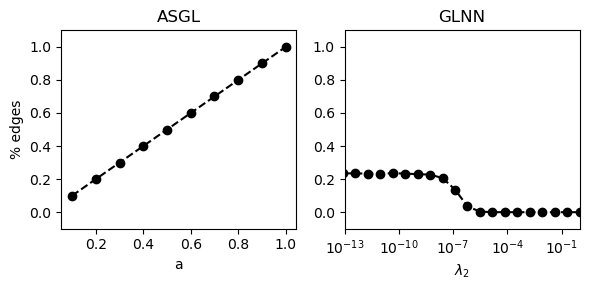

In [73]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax1.plot(a, p_ASGL, "ko--")
ax1.set_xlabel("a")
ax1.set_ylabel(f"% edges")
ax1.set_title("ASGL")
ax1.set_ylim(-0.1, 1.1)

ax2.plot(lambdas, p_GLNN, "ko--")
ax2.set_xscale('log')
ax2.set_xlabel(r"$\lambda_2$")
ax2.set_title("GLNN")
ax2.set_xlim(1e-13, 1)
ax2.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig("a_analysis.png", dpi=300)
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))  # Increased figure size

# ASGL Plot
ax1.plot(a, p_ASGL, "bo-", linewidth=2, markersize=6)  # Blue solid line with markers
ax1.set_xlabel(r"$a$", fontsize=14)
ax1.set_ylabel("% Edges", fontsize=14)
ax1.set_title("ASGL", fontsize=14)
ax1.set_ylim(-0.1, 1.1)
ax1.grid(True, linestyle="--", alpha=0.6)  # Light grid

# GLNN Plot
ax2.plot(lambdas, p_GLNN, "ro-", linewidth=2, markersize=6)  # Red solid line with markers
ax2.set_xscale('log')
ax2.set_xlabel(r"$\lambda_2$", fontsize=14)
ax2.set_title("GLNN", fontsize=14)
ax2.set_xlim(1e-13, 1)
ax2.set_ylim(-0.1, 1.1)
ax2.grid(True, linestyle="--", alpha=0.6)

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("a_analysis.png", dpi=600, bbox_inches="tight")  # High DPI and tight layout
plt.show()